# Sample queries exploring Graph structure in GEMD database


In [1]:
import SciServer.CasJobs as cj
from pprint import pprint
import json
import pandas

In [2]:
DATABASE='GEMD'

This query finds pairs of nodes with >1 path from one to the other.

In [ ]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      cast(NULL as varchar(32)) as endpoint_type
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDContext c where gemd_type='material_run'
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid, c.gemd_type
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr 
  join GEMDEdge e on e.from_uid=gr.from_uid
  join gemdcontext c on c.uid=e.to_uid
where gr.level < 16
)
select root_uid, root_type, endpoint_uid, endpoint_type
,      min(path) as path, min(level) as min_level, max(level) as max_level
,      count(*) as num_paths
  from gr
group by root_type, root_uid, endpoint_uid,endpoint_type having count(*) > 1  -- if you want to find multiple paths between nodes
 order by root_type,root_uid, endpoint_uid,path
"""
cj.executeQuery(sql, DATABASE)

Following query returns all paths between all nodes. This can be compared with the graph functionality inside MS SQL itself but is much faster.

In [ ]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+':'+c.uid as varchar(max)) as [path]
  from GEMDContext c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select root_uid, root_type, endpoint_uid
,      edge_id,gemd_ref
,      path, level
  from gr
 order by root_type,root_uid, path
"""
paths=cj.executeQuery(sql, DATABASE)

In [ ]:
edges=paths[paths['level']>0]
edges

count for each node how many distinct nodes can be reached from it

In [3]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDContext c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select root_uid, root_type, count(distinct endpoint_uid) as num_out_nodes
  from gr
group by root_type, root_uid
 order by num_out_nodes desc
"""
nodes_out=cj.executeQuery(sql, DATABASE)

CPU times: user 143 ms, sys: 68.7 ms, total: 211 ms
Wall time: 37.3 s


count for each node how many distinct nodes can reach it

In [ ]:
%%time
sql="""
with gr as (
select c.uid as root_uid
,      c.gemd_type as root_type
,      0 as level
,      cast(NULL as varchar(64)) as endpoint_uid
,      c.uid as from_uid, cast(NULL as bigint) as edge_id, cast(NULL as varchar(64)) as gemd_ref
,      cast(gemd_type+c.uid as varchar(max)) as [path]
  from GEMDContext c
 union all
select gr.root_uid, gr.root_type, gr.level+1, e.to_uid
,      e.to_uid, e.id, e.gemd_ref
,      gr.path+'==>'+e.gemd_ref+':'+e.to_uid
  from gr
  join GEMDEdge e on e.from_uid=gr.from_uid
where gr.level < 16
)
select endpoint_uid, count(distinct root_uid) as num_in_nodes
  from gr
group by endpoint_uid
 order by num_in_nodes desc
"""
nodes_in=cj.executeQuery(sql, DATABASE)

In [ ]:
nodes_out.head()

In [ ]:
nodes_in.head()

## visualize
Goal is to get a visualization vapability ala that supported by 
<a href="http://www.thebrain.com" target="_blank">http://www.thebrain.com</a>. \
This allows one to trace edges from a starting node, restricting views to only that node and nodes 1 or 2 steps away. \
Needs code development!

In [4]:
import networkx as nx
G = nx.Graph()

take a node from nodes_out and find the graph reachable from it

In [6]:
# UID = nodes_out.iloc[0].root_uid
UID = '01b44457-6ebe-43bc-b316-66fcff35957e'

In [61]:
sql=f"""
with gr as (
select c.uid as node_uid
,      c.gemd_type as node_type
,      c.context as node_context
,      cast(c.gemd_type+' ['+c.uid+']' as varchar(128)) as Target
,      cast(-1 as bigint) as edge_id
,      cast(NULL as varchar(64)) as from_uid
,      cast(NULL as varchar(128)) as Source
,      0 as level
  from GEMDContext c
  where uid='{UID}'
 union all
select c.uid as node_uid
,      c.gemd_type as node_type
,      c.context as node_context
,      cast(c.gemd_type+' ['+c.uid+']' as varchar(128)) as Target
,      e.id as edge_id
,      gr.node_uid as from_uid
,      gr.Target as Source
,      gr.level+1 as level
  from gr
  join GEMDEdge e on e.from_uid=gr.node_uid
  join GEMDContext c on c.uid=e.to_uid
where gr.level < 16
)
select Source,Target
--,node_type,node_context
  from gr
 where Source is not null
"""
gr=cj.executeQuery(sql,DATABASE)
gr

,Source,Target
0,ingredient_run [01b44457-6ebe-43bc-b316-66fcff...,material_run [f793fb2d-60b8-4389-9af5-c4f0ab6c...
1,ingredient_run [01b44457-6ebe-43bc-b316-66fcff...,process_run [de2c86e6-3751-40da-9013-f985244ff...
2,process_run [de2c86e6-3751-40da-9013-f985244ff...,process_spec [75ab28d8-a0ed-4d2e-a9d9-ee125ccd...
3,process_spec [75ab28d8-a0ed-4d2e-a9d9-ee125ccd...,process_template [c492a86a-1824-4953-a4bc-17d5...
4,material_run [f793fb2d-60b8-4389-9af5-c4f0ab6c...,material_spec [719fda10-f35f-4d5a-bf51-db851b2...
5,material_run [f793fb2d-60b8-4389-9af5-c4f0ab6c...,process_run [cf9ffbe4-5692-4ffd-bb86-8dda11ebc...
6,process_run [cf9ffbe4-5692-4ffd-bb86-8dda11ebc...,process_spec [f332db2a-9182-43fd-b6f4-4e9554e1...
7,process_spec [f332db2a-9182-43fd-b6f4-4e9554e1...,process_template [21a8148b-f605-4169-88b4-7a8a...
8,material_spec [719fda10-f35f-4d5a-bf51-db851b2...,process_spec [f332db2a-9182-43fd-b6f4-4e9554e1...
9,material_spec [719fda10-f35f-4d5a-bf51-db851b2...,material_template [c9568dff-1215-4797-8e1e-d71...


In [69]:
G=nx.from_pandas_edgelist(gr,'Source','Target',create_using=nx.DiGraph)#,'node_type')

In [70]:
G.nodes

NodeView(('ingredient_run [01b44457-6ebe-43bc-b316-66fcff35957e]', 'material_run [f793fb2d-60b8-4389-9af5-c4f0ab6c28fd]', 'process_run [de2c86e6-3751-40da-9013-f985244ffe76]', 'process_spec [75ab28d8-a0ed-4d2e-a9d9-ee125ccd00fb]', 'process_template [c492a86a-1824-4953-a4bc-17d52fbecf1c]', 'material_spec [719fda10-f35f-4d5a-bf51-db851b2d31fc]', 'process_run [cf9ffbe4-5692-4ffd-bb86-8dda11ebcc22]', 'process_spec [f332db2a-9182-43fd-b6f4-4e9554e1c609]', 'process_template [21a8148b-f605-4169-88b4-7a8a2b3a2d6a]', 'material_template [c9568dff-1215-4797-8e1e-d7148e8ae6c3]'))

In [71]:
nx.draw_spring(G)  # seems not to work in JupyterLab

## plot using bokeh
Needs more work. Canot deal with DiGraphs

In [66]:
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx

In [51]:
output_notebook()

Loading BokehJS ...

In [74]:
#Choose a title!
title = f'graph rooted in {UID}'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Source", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              tooltips = HOVER_TOOLTIPS,
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")

## plot using netgraph
Seeming problems in JupyterLab

In [53]:
pip install netgraph

Note: you may need to restart the kernel to use updated packages.


In [19]:
import netgraph # 

In [78]:
%matplotlib notebook
import IPython

In [79]:
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
import networkx


# Construct sparse, directed, weighted graph
total_nodes = 20
weights = np.random.rand(total_nodes, total_nodes)
connection_probability = 0.1
is_connected = np.random.rand(total_nodes, total_nodes) <= connection_probability
graph = np.zeros((total_nodes, total_nodes))
graph[is_connected] = weights[is_connected]

# construct a networkx graph
# g = networkx.from_numpy_array(graph, networkx.DiGraph)

# decide on a layout
pos = networkx.layout.spring_layout(G)

# Create an interactive plot.
# NOTE: you must retain a reference to the object instance!
# Otherwise the whole thing will be garbage collected after the initial draw
# and you won't be able to move the plot elements around.
plot_instance = netgraph.InteractiveGraph(G, node_positions=pos)

######## drag nodes around #########

# To access the new node positions:
node_positions = plot_instance.node_positions

<IPython.core.display.Javascript object>

## display using pydot
Not interactive.

In [26]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [72]:
import pydot
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

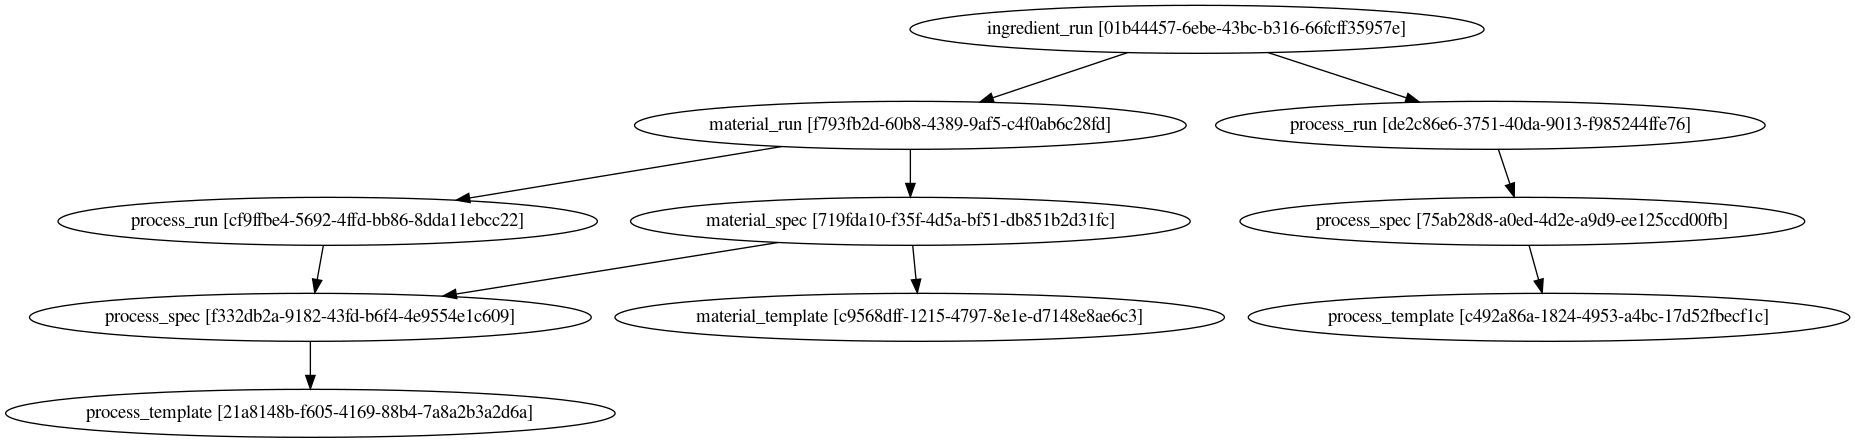

In [73]:
dotG=nx.nx_pydot.to_pydot(G)
view_pydot(dotG)